Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Gasper Bizjan"

---

## Assignment 9 - Reference Map and Global P1-Basis


### 9.1 Reference Map 
In the Codeblock below there is the class ```Grid``` you know from the last assignments. The aim of this assignment is to implement missing functionality for a Grid to be used with a Finite Element software. The reference map $F_T : \hat{T} \rightarrow T$ is always affine linear as we have seen before:<br><br>
$$ 
F_T (\hat{x},\hat{y}) = \left[\matrix a_1-a_0,a_2-a_0 \right]\hat{x} + a_0 \\
DF_T(\hat{x},\hat{y}) = \left[\matrix a_1-a_0,a_2-a_0 \right]
$$ 
<br>
is simply given by the linear part and the definitions of the determinant as well as the Inverse follow immediately. 

#### 9.1.1 updateTrafoInformation

Complete the member function ```updateTrafoInformation```. You can find the function header in class below. The function should update the properties 
<br><br> ```self.adet``` array of shape $N_{cells}$ which represents $|det {DF}_T|$ for all cells $T \in \tau_h$. 
<br><br> ```self.invJacT``` array of shape $N_{cells}\times 2 \times 2$ which represents the transposed inverse of transformation gradient $({DF}_T)^{-T}$ for all cells $T \in \tau_h$.
<br><br>
<b>INPUT</b>: no input <br>
<b>OUTPUT</b>: no output <br><br>

#### 9.1.2 evalReferenceMap
Complete the member function ```evalReferenceMap```. You can find the function header and its return value in class below. The function should evaluate the Reference Map $F_T$ in a set of points in the Reference Element ```xHat```.

<b>INPUT</b>: ```xHat```, set of $N_p$ points in the reference element as ```np.array([ [x1,y1] , [x2 , y2] , ... ])``` of shape $N_p \times 2$. <br>
<b>OUTPUT</b>: ```np.ndarray``` of shape $N_{cells}\times N_p \times 2$

Hints:<br> 
$(\hat{x}_j , \hat{y}_j) = $ ```xHat[j,:]```<br>
$ F_T(\hat{x}_j,\hat{y}_j)_k = $ ``` evalReferenceMap(xHat)[T,j,k] ``` 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class Grid():
    def __init__(self,xlow,xhigh,ylow,yhigh,Nx,Ny):
        self.xlow = xlow
        self.xhigh = xhigh
        self.ylow = ylow
        self.yhigh = yhigh
        self.Nx = Nx
        self.Ny = Ny 
        
        self.createGrid()
        
        # create the determinant and the Inverse of the Jacobian 
        self.adet = None
        self.invJacT = None
        self.updateTrafoInformation()
        
    def createGrid(self):
        x = np.linspace(self.xlow,self.xhigh,self.Nx)
        y = np.linspace(self.ylow,self.yhigh,self.Ny)    
            
        # meshgrid -> #nodes x 2
        self.points = np.zeros([self.Nx*self.Ny,2])
        self.points[:,0] = np.kron( np.ones(self.Ny) , x )   # Ny times copy of x
        self.points[:,1] = np.kron( y , np.ones(self.Nx)  )  # Nx y[0]  and  Nx y[1]  and ...  
    
        # 1 and 2 initial the first two triangles and copy it 
        self.cells = np.zeros([2*(self.Nx-1)*(self.Ny-1),3],dtype=int)
        self.cells[0::2] = [0,1,self.Nx]
        self.cells[1::2] = [self.Nx+1,self.Nx,1]
    
        # 3 row index shift
        shift = np.arange(0,(self.Nx-1)*(self.Ny-1))
        shift = np.kron(shift , np.ones(2,dtype=int)  )    
        self.cells = self.cells + shift[:,None]

        shift = np.arange(0,self.Ny-1)
        shift = np.kron( shift , np.ones(2*(self.Nx-1),dtype=int) )    
        self.cells = self.cells + shift[:,None]

        
    def show(self):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.axis('equal')

        ax.scatter(self.points[:,0] , self.points[:,1])
        ax.triplot(self.points[:,0],self.points[:,1], self.cells)
    
        plt.show()   


    def isBoundaryPoint(self,p):
        return ((p[0] <= self.xlow+1e-6 or p[0] >= self.xhigh-1e-6) or (p[1] <= self.ylow + 1e-6 or p[1] >= self.yhigh - 1e-6))

    def updateTrafoInformation(self):
        # self.adet = abs(det(DF))
        # self.invJacT
        
        verts = self.points[self.cells] # Nc x 3 x 2 coordinates of all the cells
        # det(DF)
        # det(A)= ad - bc
        det = np.multiply(verts[:,1,0]-verts[:,0,0], verts[:,2,1]-verts[:,0,1])-np.multiply(verts[:,2,0]-verts[:,0,0], verts[:,1,1]-verts[:,0,1])
        
        # adjoint matrices and transposed - lecture 3
        firstCol = np.stack((verts[:,2,1]-verts[:,0,1], verts[:,0,0]-verts[:,2,0]), axis=1)
        secondCol = np.stack((verts[:,0,1]-verts[:,1,1], verts[:,1,0]-verts[:,0,0]), axis=1)
        adjMatT = np.stack((firstCol, secondCol), axis=2)
        
        # adjMatT - Nc x [2 x 2]
        # det     - Nc
        #adjMatT / det
        
        self.invJacT = np.divide(adjMatT, det[:,None,None])
        self.adet = np.abs(det)

    def evalReferenceMap(self, xHat):
        # FT(x) = Ax + b
        
        verts = self.points[self.cells]
        trafoVec = verts[:,0,:] # Nc x 2 global point corresponding to origin of the reference element
        trafoMat = np.stack((verts[:,1:]-verts[:,0,:], verts[:,2,:]-verts[:,0,:]), axis=2) # Nc x [2 x 2]
        
        # xHat Np x 2
        # trafoX FT(xHat)  Nc x Np x 2
        trafoX = trafoMat[:,None,:,0] * xHat[None,:] + trafoMat[:,None,:,1] * xHat[None,:] + trafoVec[:,None]
        
        return trafoX

Transpose of the inversed Jacobian:
[[[ 3.  0.]
  [ 0.  3.]]

 [[-3.  0.]
  [ 0. -3.]]

 [[ 3.  0.]
  [ 0.  3.]]

 [[-3.  0.]
  [ 0. -3.]]

 [[ 3.  0.]
  [ 0.  3.]]

 [[-3.  0.]
  [ 0. -3.]]

 [[ 3.  0.]
  [ 0.  3.]]

 [[-3.  0.]
  [ 0. -3.]]

 [[ 3.  0.]
  [ 0.  3.]]

 [[-3.  0.]
  [ 0. -3.]]

 [[ 3.  0.]
  [ 0.  3.]]

 [[-3.  0.]
  [ 0. -3.]]

 [[ 3.  0.]
  [ 0.  3.]]

 [[-3.  0.]
  [ 0. -3.]]

 [[ 3.  0.]
  [ 0.  3.]]

 [[-3.  0.]
  [ 0. -3.]]

 [[ 3.  0.]
  [ 0.  3.]]

 [[-3.  0.]
  [ 0. -3.]]]



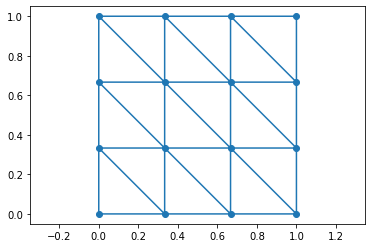

In [3]:
# The reference Map maps the reference element to the grid. 
# Plaese use the following trivial example to check your result. 

g = Grid(0,1,0,1,4,4)

print("Transpose of the inversed Jacobian:")
print(g.invJacT)
print()
g.show()

### 9.2 Practice the DOF-Mapping

Consider the simple triangular grid depicted in the file <i>tri_grid.png</i> and given by<br> 
$$ points = \begin{bmatrix} 
0.0 & 0.0 \\
0.5 & 0.0 \\
1.0 & 0.0 \\
0.0 & 0.5 \\
0.5 & 0.5 \\
1.0 & 0.5 \\
0.0 & 1.0 \\
0.5 & 1.0 \\
1.0 & 1.0 \end{bmatrix} \quad cells = \begin{bmatrix}
0 & 1 & 3 \\
4 & 3 & 1 \\
1 & 2 & 4 \\
5 & 4 & 2 \\
3 & 4 & 6 \\
7 & 6 & 4 \\
4 & 5 & 7 \\
8 & 7 & 5\end{bmatrix} $$

and focus on $P_4$ again. Then global $\varphi_4$ corresponds with the local basis functions 
<ul>
    <li> $\phi_0$ on cells $T_1$ and $T_6$  </li>
    <li> $\phi_1$ on cells $T_3$ and $T_4$  </li> 
    <li> $\phi_2$ on cells $T_2$ and $T_5$. </li>
</ul>
On triangles $T_0$ and $T_7$ it does not correspond with any local basis function.<br> <br>
Write down the local index for the given global index and cell. The format does not have to fulfill any requirements, filling in a number is sufficient. <br>
<b>Important:</b> 
Use the Pythonic numbering, starting at index $0$ and if a cell doesn't corresponce to a node use $-1$. 





![tri_grid](tri_grid.png)

Global Index: 7 <br>
Cell: 7

local index: 1

Global Index: 5 <br>
Cell: 3

local index: 0

Global index: 7<br> 
Cell: 5

local index: 0

Global index: 3<br> 
Cell: 4

local index: 0 

### 9.3 Global P1-Basis
We will write a class ```GlobalBasis``` which gets a grid and local basis as members and creats the global P1-Basis as introduced in the lecture. 

Use the file ```basis.py``` to import the class ```Basis```. Creat a basis on the reference element called ```b```. 

In [30]:
from basis import Basis
b = Basis()

#### 9.3.1 Introduction

Consider a global basis where the function $\varphi_i$ directly corresponds to the basis functions on the reference element $\hat{\phi}_k$ by 

$$ 
\varphi_i(x) = \phi^T_{D(i,T)}(x) = \hat{\phi}_{D(i,T)}(F^{-1}(x))
$$

and fullfils the lagrangian condition with respecte to the point $P_i$
$$ \varphi_i(P_j) = \begin{cases}
1 & \text{ if }i=j\\
0 & \text{ if }i\neq j
\end{cases} $$
so that it has value $1$ at point $P_i$ and $0$ at all other points. The support of $\varphi_i$, i.e. the part of the domain where $\varphi_i$ is nonzero is given by the cells surrounding $P_i$. But what if we actually are in a cell $T$ surrounding $P_i$? For the application of Finite Element methods one usually needs - for a given global index $i$ - the local indices on <i>all</i> cells in the support, i.e. all surrounding cells. Thus we want to implement a different variant of this functionality, returning both the indices of all cells in the support and the local indices in those cells. <br><br>

#### 9.2.1 Constructor 

The contructor has the input <br>
<b>INPUT</b>: ```grid``` a grid class, ```basis``` a local basis. <br><br> 
Hint: For the ```Grid``` we can use the class defined above and basis ```Basis``` is imported by the task above. 

#### 9.2.2 evalDofMap

Implement the member function ```evalDOFMap```. <br>
<b>INPUT:</b> ```globalInd``` - the global index (previously denoted by $i$) as ```int``` <br>
<b>OUTPUT:</b> ```supp``` - indices of cells in the support as ```np.ndarray```, ```localInd``` - corresponding local basis indices as ```np.ndarray```. 
<br>
Consider for example the previously defined triangular grid. Then for an input of the global index $4$ one would get the outputs 
<ul>
<li>$[1,2,3,4,5,6]$ - indices of all cells in the support </li>
<li>$[0,2,1,1,2,0]$ - corresponding local indices for global index $4$ </li>
</ul>



In [31]:
class GlobalBasis:
    def __init__(self, grid, basis):
        self.grid = grid
        self.basis = basis

    def evalDOFMap(self, globalInd):
        supp, localInd = np.where(self.grid.cells==globalInd) # bool array Nc x 3 => np.where the booy array is true
        return supp, localInd

In [32]:
g = Grid(0,1,0,1,3,3)
try:
    b = basis.Basis()
except:
    b = Basis()
globalBasis = GlobalBasis(g,b)

# Test
print("supp: ", globalBasis.evalDOFMap(4)[0])
print("localInd: ", globalBasis.evalDOFMap(4)[1])

supp:  [1 2 3 4 5 6]
localInd:  [0 2 1 1 2 0]


In [33]:
g = Grid(0,1,0,1,10,10)
try:
    b = basis.Basis()
except:
    b = Basis()
globalBasis = GlobalBasis(g,b)

globalBasis.evalDOFMap(9)

(array([16, 17], dtype=int64), array([1, 2], dtype=int64))